# Neural IBM1 - Task 4

We implemented this model with a few specific choices. For computing the value of alfa and beta for the Kumaraswamy distribution, we combine $f_{j-1}$ and $f_j$ by concatenating their embeddings, in much the same way as in T2. Furthermore, as hinted in the tips, we clip the parameters for the Beta and Kumaraswamy distributions between $[0.001, \infty]$, and made sure the KL was never negative by clipping it from below to 0. This seems to have solved the numerical issues we had before.

In [1]:
#imports
import tensorflow as tf
import numpy as np
from pprint import pprint
import pickle
from statstracker import StatsTracker
%pylab inline
from utils import smart_reader, bitext_reader, iterate_minibatches, prepare_data
from vocabulary import OrderedCounter, Vocabulary

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Get vocab
train_e_path = 'data/training/hansards.36.2.e.gz'
train_f_path = 'data/training/hansards.36.2.f.gz'
dev_e_path = 'data/validation/dev.e.gz'
dev_f_path = 'data/validation/dev.f.gz'
dev_wa = 'data/validation/dev.wa.nonullalign'
test_e_path = 'data/test/test.e.gz'
test_f_path = 'data/test/test.f.gz'
test_wa = 'data/test/test.wa.nonullalign'

max_tokens=1000

corpus_e = smart_reader(train_e_path)
vocabulary_e = Vocabulary(corpus=corpus_e, max_tokens=max_tokens)
# pickle.dump(vocabulary_e, open("vocabulary_e.pkl", mode="wb"))

corpus_f = smart_reader(train_f_path)
vocabulary_f = Vocabulary(corpus=corpus_f, max_tokens=max_tokens)
# pickle.dump(vocabulary_f, open("vocabulary_f.pkl", mode="wb"))

test_corpus = list(bitext_reader(
            smart_reader(test_e_path),
            smart_reader(test_f_path)))

In [3]:
#Get model for Task 4
from neuralibm1_T4 import NeuralIBM1Model_T4

# check neuralibm1trainer.py for the Trainer code
from neuralibm1trainer import NeuralIBM1Trainer_T2_gate

Task 4
Training with B=128 max_length=30 lr=0.001 lr_decay=0.0
Initializing variables..
Training started..
Shuffling training data
Iter   100 loss 54.649399 accuracy 0.18 lr 0.001000
Iter   200 loss 49.608334 accuracy 0.23 lr 0.001000
Iter   300 loss 47.978786 accuracy 0.25 lr 0.001000
Iter   400 loss 38.489471 accuracy 0.31 lr 0.001000
Iter   500 loss 44.124008 accuracy 0.31 lr 0.001000
Iter   600 loss 46.326622 accuracy 0.28 lr 0.001000
Iter   700 loss 40.346237 accuracy 0.30 lr 0.001000
Iter   800 loss 45.798080 accuracy 0.27 lr 0.001000
Iter   900 loss 44.732910 accuracy 0.27 lr 0.001000
Iter  1000 loss 47.897877 accuracy 0.29 lr 0.001000
Iter  1100 loss 39.542614 accuracy 0.30 lr 0.001000
Iter  1200 loss 42.489090 accuracy 0.29 lr 0.001000
Iter  1300 loss 39.811764 accuracy 0.30 lr 0.001000
Epoch 1 loss 45.382687 accuracy 0.27 val_aer 0.99 val_acc 0.27
Model saved in file: D:\Userdata\Sync\universiteit\MSc\Jaar 1\Natural Language Processing 2\nlp2\project 3\model.ckpt
Shuffling tr

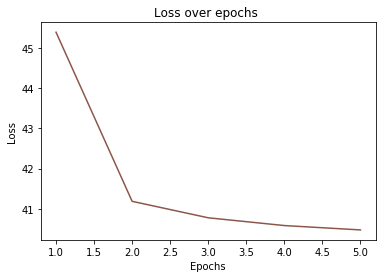

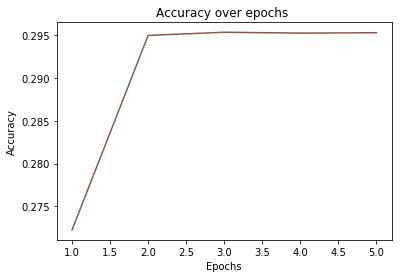

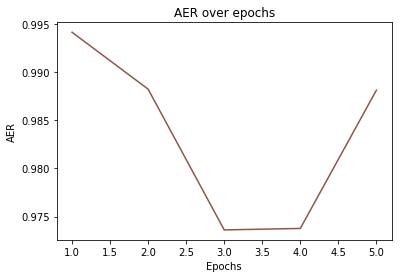

In [4]:
# Run model task 4
tf.reset_default_graph()

with tf.Session() as sess:

  print("Task 4")
  # some hyper-parameters
  # tweak them as you wish
  batch_size=128  # on CPU, use something much smaller e.g. 1-16
  max_length=30
  lr = 0.001
  lr_decay = 0.0  # set to 0.0 when using Adam optimizer (default)
  emb_dim = 64
  mlp_dim = 128

  stats_tracker = StatsTracker()
  # our model
  model = NeuralIBM1Model_T4(
    x_vocabulary=vocabulary_e, y_vocabulary=vocabulary_f,
    batch_size=batch_size, emb_dim=emb_dim, mlp_dim=mlp_dim, session=sess)

  # our trainer
  trainer = NeuralIBM1Trainer_T2_gate(
    model, train_e_path, train_f_path,
    dev_e_path, dev_f_path, dev_wa,
    num_epochs=5, batch_size=batch_size,
    max_length=max_length, lr=lr, lr_decay=lr_decay, session=sess)

  # now first TF needs to initialize all the variables
  print("Initializing variables..")
  sess.run(tf.global_variables_initializer())

  # now we can start training!
  print("Training started..")
  trainer.train(stats_tracker)
    
  test_aer, test_acc = trainer.model.evaluate(
                test_corpus, test_wa)   
  print("Testset accuracy: {}, AER: {}".format(test_acc, test_aer))